## **Set up**

In [ ]:
!pip install pyspark
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Credit Fraud Project").getOrCreate()

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from time import time
import pandas as pd
import seaborn as sns
import numpy as np

## **Load dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/dataset/creditcard.csv'

credit_card_df = spark.read.csv(path, header=True, inferSchema=True)
credit_card_df.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

In [ ]:
credit_card_df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [ ]:
credit_card_df.summary().show()

+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|              Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|

In [ ]:
print(credit_card_df.count(), len(credit_card_df.columns))

284807 31


#### There are **284,807** instances and **31** features

## **Visualize target and features variables distributions**

### Target variable

In [ ]:
# count # of each label
target_counts = credit_card_df.groupBy("Class").count()

# convert to pandas dataframe
target_counts_pd = target_counts.toPandas()

target_counts_pd = target_counts_pd.sort_values(by="Class")

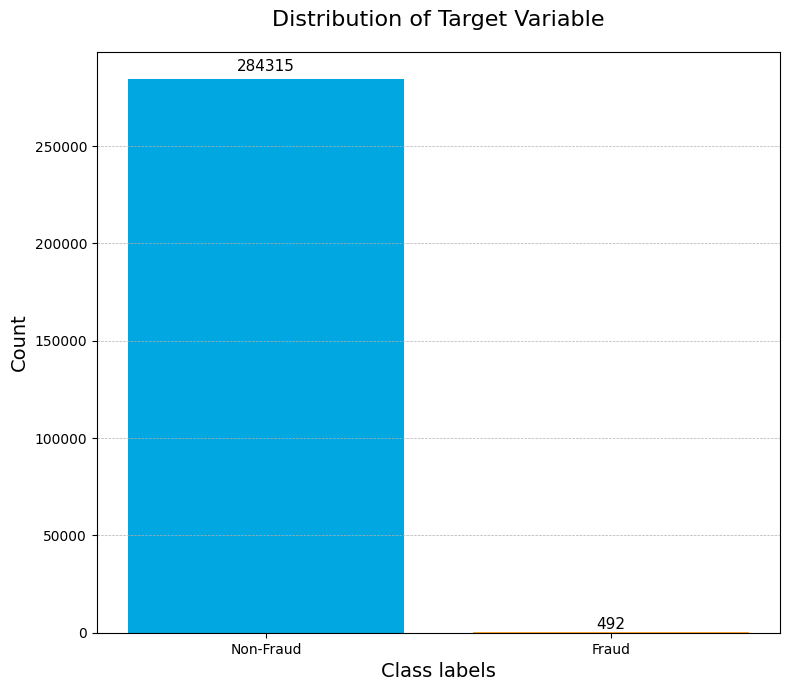

In [ ]:
plt.figure(figsize=(8, 7))
bars = plt.bar(target_counts_pd["Class"], target_counts_pd["count"], color=['#00a7e1', '#ffa630'])
plt.xlabel("Class labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Target Variable", fontsize=16, y=1.03)

# set x-ticks to only show 0 and 1
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])

# annotate each bar with the count
for bar, count in zip(bars, target_counts_pd["count"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01 * bar.get_height(),
        f"{count}",
        ha='center',
        va='bottom',
        fontsize=11,
    )
plt.grid(axis = 'y',  linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.savefig('fraud-vs-non.png')
plt.show()

In [ ]:
print(284315/credit_card_df.count() * 100)
print(492/credit_card_df.count() * 100)

99.82725143693798
0.1727485630620034


### Feature variables
* As V1 to V28 are PCA-transformed features, we only visualize the `Time` and `Amount` variables
* Feature `Time` represents the seconds elapsed between each transaction and the first transaction in the dataset

In [ ]:
credit_card_pd = credit_card_df.toPandas()

fraud = credit_card_pd[credit_card_pd['Class'] == 1]
non_fraud = credit_card_pd[credit_card_pd['Class'] == 0]

#### Feature distribution

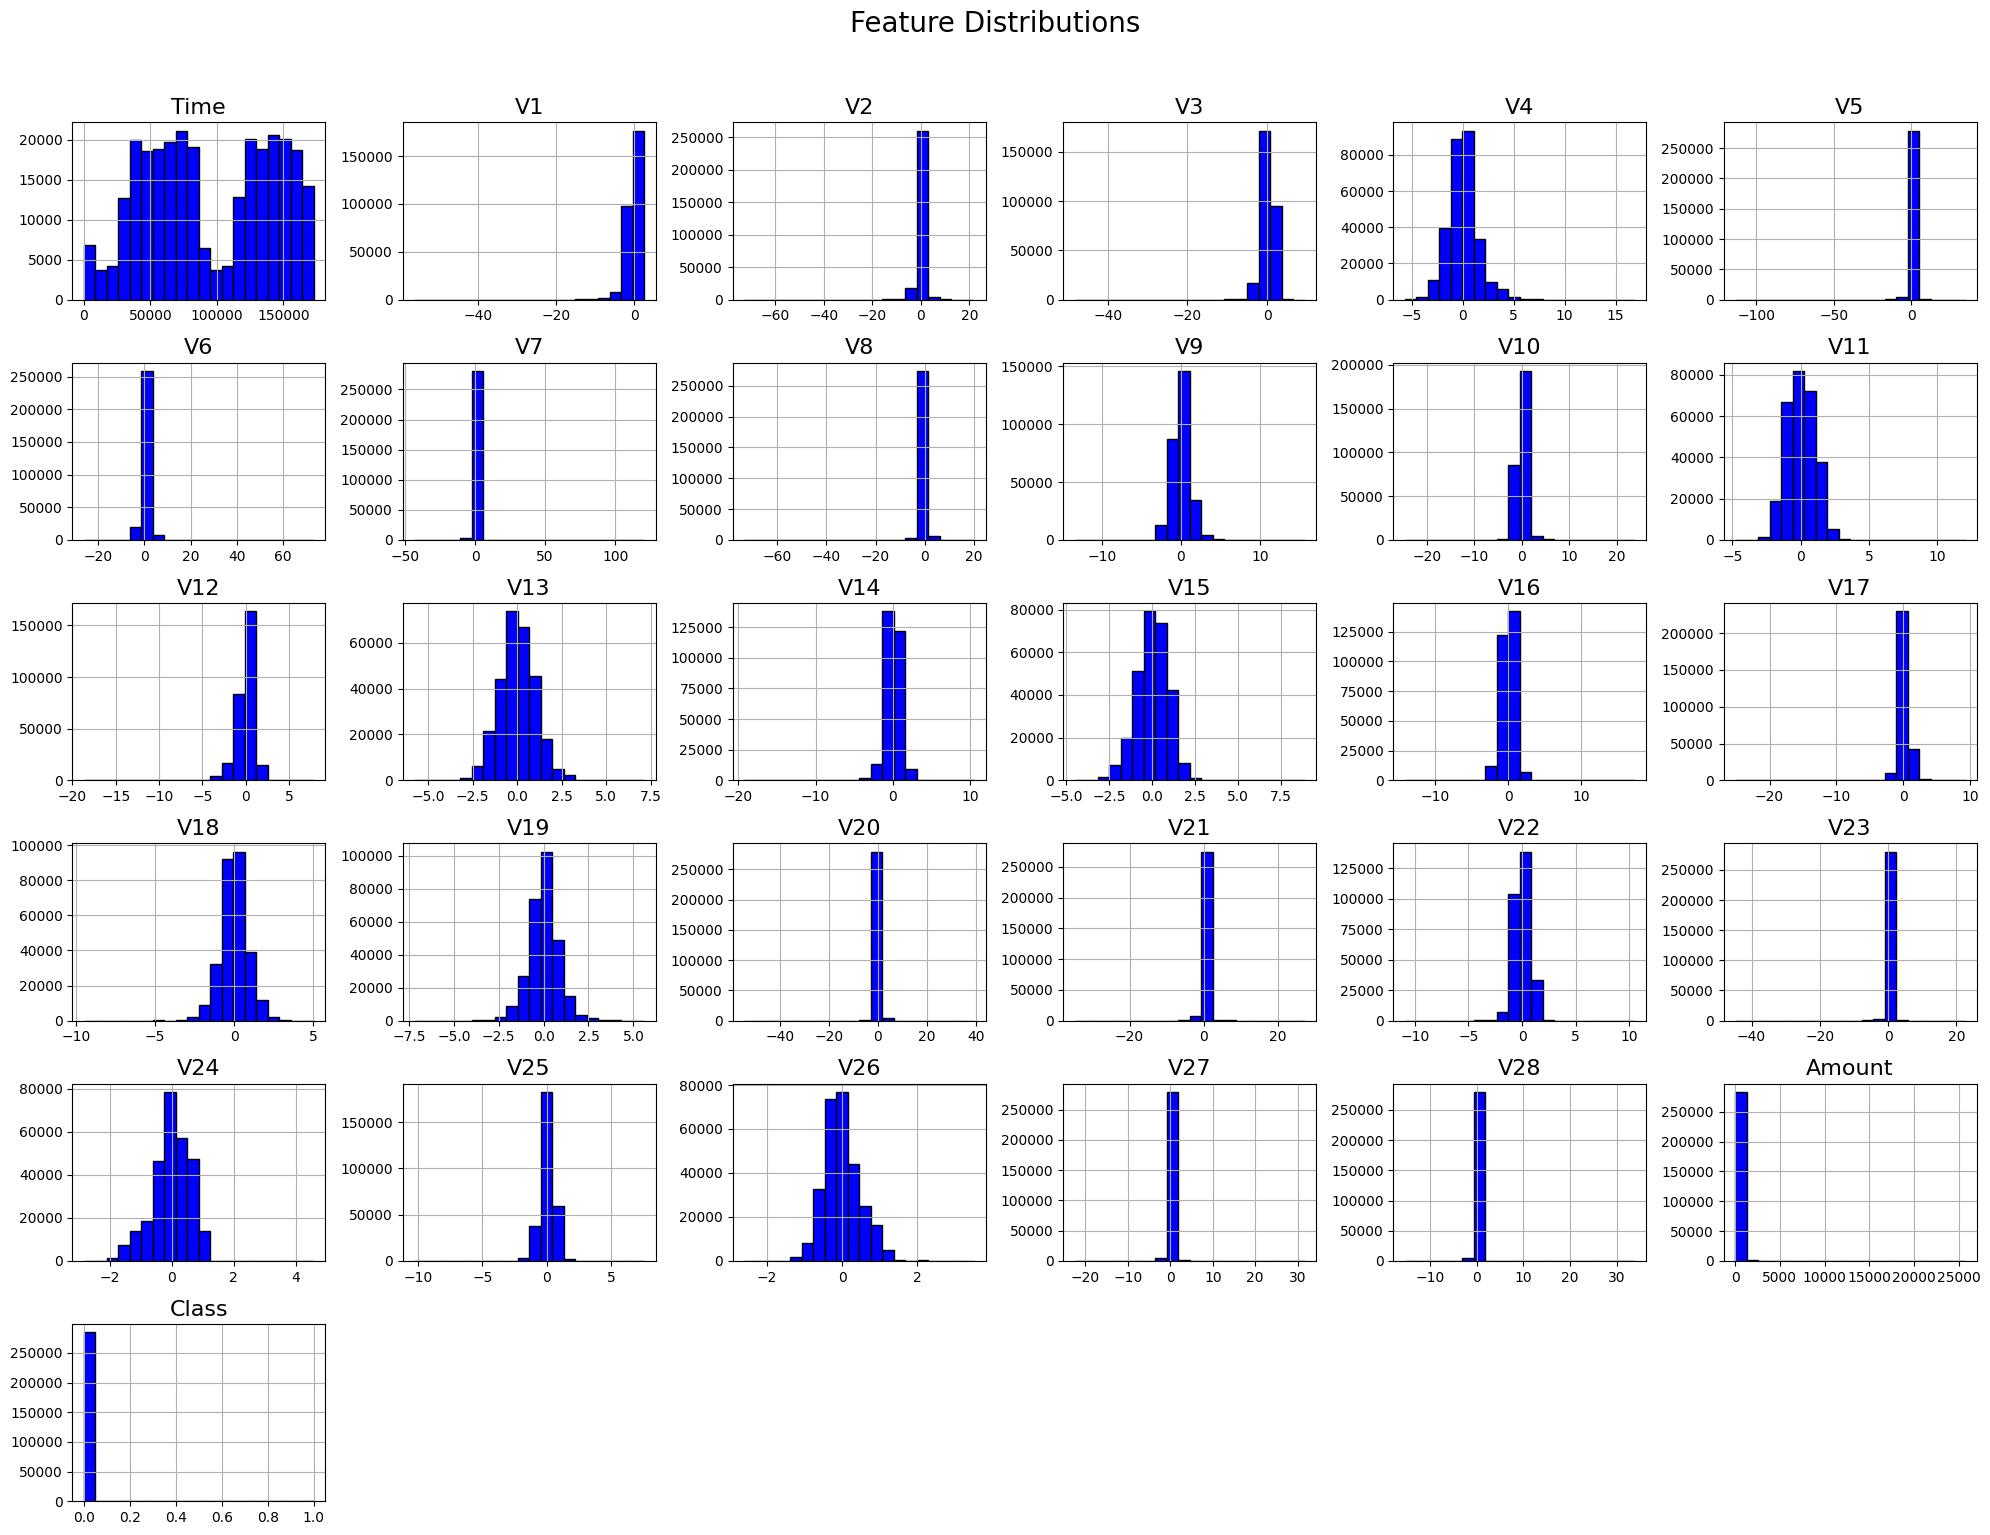

In [ ]:
axes = credit_card_pd.hist(bins=20, figsize=(20, 15), color='blue', edgecolor='black')

# Set font size for titles of each feature (histogram)
for ax in axes.flatten():  # Flatten the axes to iterate through all subplots
    ax.set_title(ax.get_title(), fontsize=16)  # Adjust fontsize as needed

# Main title for the figure
plt.suptitle("Feature Distributions", fontsize=20, y=1.02)

# Display the plot
plt.tight_layout()
plt.savefig('histogram.png')
plt.show()

#### Relationship between `Time` and `Amount`

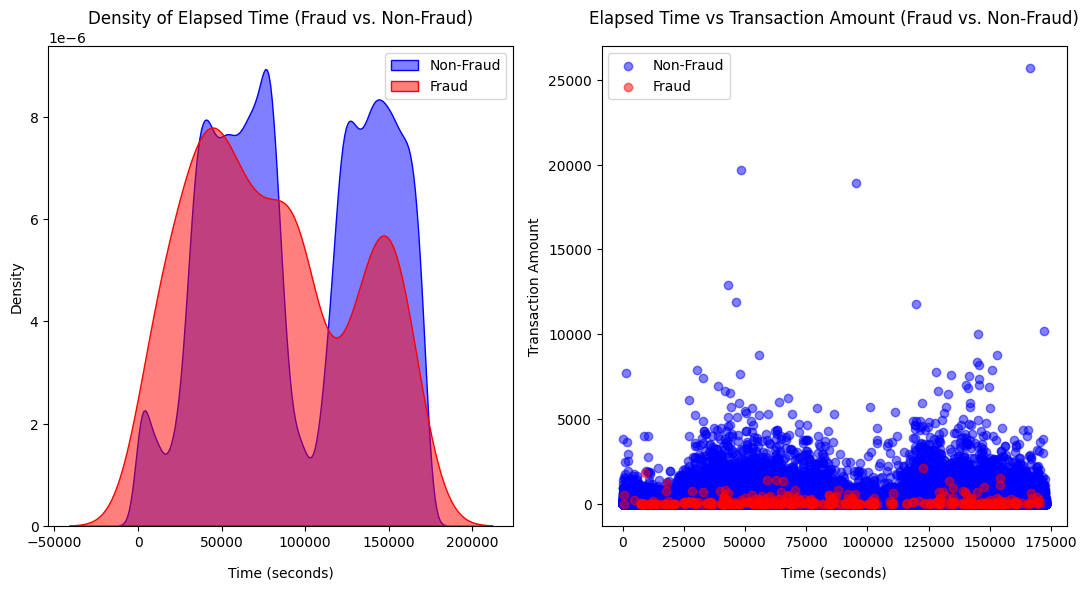

In [ ]:
plt.figure(figsize=(11, 6))

# plot Kernel Density Estimation
# visualize the probability density function of time distribution
plt.subplot(1, 2, 1)
sns.kdeplot(non_fraud['Time'], fill=True, color='blue', alpha=0.5, label='Non-Fraud')
sns.kdeplot(fraud['Time'], fill=True, color='red', alpha=0.5, label='Fraud')
plt.title('Density of Elapsed Time (Fraud vs. Non-Fraud)', y=1.03)
plt.xlabel('Time (seconds)', labelpad=12)
plt.ylabel('Density')
plt.legend()

# plot time, non-fraud, fraud with associated amounts
plt.subplot(1, 2, 2)
plt.scatter(non_fraud['Time'], non_fraud['Amount'], alpha=0.5, label='Non-Fraud', color='blue')
plt.scatter(fraud['Time'], fraud['Amount'], alpha=0.5, label='Fraud', color='red')
plt.title('Elapsed Time vs Transaction Amount (Fraud vs. Non-Fraud)', y=1.03)
plt.xlabel('Time (seconds)', labelpad=12)
plt.ylabel('Transaction Amount')
plt.legend()

plt.tight_layout()
plt.savefig('amount-vs-time.png')
plt.show()

**Interpretation**
* **Density of Elapsed Time**
  > The fraudulent and non-fraudulent transactions have **overlapping distributions**, indicating that time alone is not a perfect separator for identifying fraud

  > The non-fraud curve has multiple peaks, suggesting **distinct clusters** of transaction times. These might correspond to different user behaviors or transaction patterns at specific times of the day.
  The fraud curve has a more concentrated shape with fewer peaks, indicating less variability in fraudulent transactions over time

  > The time distribution of fraudulent transactions appears more focused, while non-fraudulent transactions are spread out over a longer time range

* **Elapsed Time vs. Transaction Amount**

  > Fraudulent transactions mostly occur at lower transaction amounts.
  Non-fraudulent transactions cover a wider range of amounts, including some very high-value transactions

  > Both fraudulent and non-fraudulent transactions occur throughout the elapsed time range, though fraud cases are less frequent and appear scattered

  > It can be concluded that fraudulent transactions might deliberately avoid large amounts to evade detection, focusing on smaller values distributed over time

### **Summary**
* The transaction amount is relatively small. The mean of all the amounts made is approximately **$88.35**
* There are no "Null" values existed in the dataset
* Most of the transactions were non-fraud **(99.83%)** of the time, while fraud transactions occurs **(0.17%)** of the time in the dataframe
* There is an imbalanced in our original dataset as most of the transactions are non-fraud so `Stratified Sampling` will be used

# **New approach**

## **Preprocessing**

### Split data to 80:20 using `Stratified Sampling` technique


In [ ]:
label_counts = target_counts.collect()
fraud_count = next(row["count"] for row in label_counts if row["Class"] == 1)
non_fraud_count = next(row["count"] for row in label_counts if row["Class"] == 0)

In [ ]:
print(label_counts)
print(fraud_count, non_fraud_count)

[Row(Class=1, count=492), Row(Class=0, count=284315)]
492 284315


In [ ]:
# obtain fraud and non-fraud ratio
total_count = fraud_count + non_fraud_count
fraud_ratio = fraud_count / total_count
non_fraud_ratio = non_fraud_count / total_count

print(fraud_ratio, non_fraud_ratio)

0.001727485630620034 0.9982725143693799


In [ ]:
# determine split size
train_size = 0.6 * total_count
test_size = 0.2 * total_count

In [ ]:
# calculate expected counts for each class in each train/val/test
train_fraud_count = int(fraud_ratio * train_size)
train_non_fraud_count = int(non_fraud_ratio * train_size)

test_fraud_count = int(fraud_ratio * test_size)
test_non_fraud_count = int(non_fraud_ratio * test_size)

print(train_fraud_count, train_non_fraud_count)
print(test_fraud_count, test_non_fraud_count)

295 170588
98 56863


In [ ]:
# split fraud cases
fraud_df = credit_card_df.filter("Class = 1")
train_fraud = fraud_df.sample(False, train_fraud_count / fraud_count, seed=42)
test_fraud = fraud_df.sample(False, test_fraud_count / fraud_count, seed=42)

# split non-fraud cases
non_fraud_df = credit_card_df.filter("Class = 0")
train_non_fraud = non_fraud_df.sample(False, train_non_fraud_count / non_fraud_count, seed=42)
test_non_fraud = non_fraud_df.sample(False, test_non_fraud_count / non_fraud_count, seed=42)

In [ ]:
# combine fraud and non-fraud subsets for each split:
train_df = train_fraud.union(train_non_fraud)
test_df = test_fraud.union(test_non_fraud)

### **Create undersampled, oversampled, and combination of both**

In [ ]:
# [stratified, oversampled, undersampled, oversampled + undersampled]


In [ ]:
# convert train_df to pandas
train_pd = train_df.toPandas()

X_train = train_pd.drop(columns=["Class"])
y_train = train_pd["Class"]

#### `RandomUnderSampler`





In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# initialize UnderSampler object
under = RandomUnderSampler()

# apply RandomUnderSampler on the training set
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

# Convert resampled data back to a PySpark DataFrame
train_under = pd.concat([X_train_under, y_train_under], axis=1)
train_under_df = spark.createDataFrame(train_under)

#### `SMOTE`

In [ ]:
from imblearn.over_sampling import SMOTE

# initialize SMOTE object
over = SMOTE()

# apply SMOTE on the training set
X_train_smote, y_train_smote = over.fit_resample(X_train, y_train)

# Convert resampled data back to a PySpark DataFrame
train_over = pd.concat([X_train_smote, y_train_smote], axis=1)
train_over_df = spark.createDataFrame(train_over)

#### `SMOTE + RandomUnderSampler`

In [ ]:
from imblearn.pipeline import Pipeline

over_resam = SMOTE(sampling_strategy=0.2)
under_resam = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over_resam), ('u', under_resam)]
pipeline = Pipeline(steps=steps)

# resampling the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Convert resampled data back to a PySpark DataFrame
train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
train_resampled_df = spark.createDataFrame(train_resampled)

#### View difference in class distributions

In [ ]:
# List to collect results
results = []

# Loop through datasets and calculate distributions
for dataset, name in zip([train_df, train_under_df, train_over_df, train_resampled_df, test_df],
                         ["Train", "Train Under Resampled", "Train Over Resampled", "Train Resampled with both", "Test"]):
    counts = dataset.groupBy("Class").count().collect()
    total = sum(row["count"] for row in counts)
    non_fraud_count = next(row["count"] for row in counts if row["Class"] == 0)
    fraud_count = next(row["count"] for row in counts if row["Class"] == 1)
    non_fraud_ratio = non_fraud_count / total * 100
    fraud_ratio = fraud_count / total * 100

    # Append results as a dictionary
    results.append({
        "Set": name,
        "Non-fraud": non_fraud_count,
        "Fraud": fraud_count,
        "Non-fraud %": f"{non_fraud_ratio:.2f}%",
        "Fraud %": f"{fraud_ratio:.2f}%"
    })

# Convert results to a Pandas DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df

,Set,Non-fraud,Fraud,Non-fraud %,Fraud %
0,Train,170903,298,99.83%,0.17%
1,Train Under Resampled,298,298,50.00%,50.00%
2,Train Over Resampled,170903,170903,50.00%,50.00%
3,Train Resampled with both,68360,34180,66.67%,33.33%
4,Test,57367,106,99.82%,0.18%


## **Apply `Standard Scaler` to standardize `Amount` feature**

In [ ]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

# initialize vector object for Amount feature
vector_amount = VectorAssembler(inputCols=["Amount"], outputCol="vector_amount")

# vectorized Amount in train set
train_df_amount = vector_amount.transform(train_df)

# vectorized Amount in train undersampled set
train_under_df_amount = vector_amount.transform(train_under_df)

# vectorized Amount in train oversampled set
train_over_df_amount = vector_amount.transform(train_over_df)

# vectorized Amount in train both set
train_both_df_amount = vector_amount.transform(train_resampled_df)

# vectorized Amount in test set
test_df_amount = vector_amount.transform(test_df)

In [ ]:
# initialize StandardScaler()
scaler = StandardScaler(inputCol="vector_amount", outputCol="scaled_amount", withMean=True, withStd=True)

# apply Scaler on train_df_amount
scale_model = scaler.fit(train_df_amount)
train_df_scaled = scale_model.transform(train_df_amount)

train_under_df_scaled = scale_model.transform(train_under_df_amount)

train_over_df_scaled = scale_model.transform(train_over_df_amount)

train_both_df_scaled = scale_model.transform(train_both_df_amount)

# apply Scaler on test_df_amount
test_df_scaled = scale_model.transform(test_df_amount)

## **Convert scaled Amount and V1-V28 features into a single feature vector**

In [ ]:
train_df_scaled.show(5, truncate=False)

+------+-------------------+-----------------+-----------------+----------------+-----------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------+-----+-------------+----------------------+
|Time  |V1                 |V2               |V3               |V4              |V5               |V6               |V7                |V8                 |V9                |V10               |V11               |V12               |V13               |V14              |V15                 |V16               |V17              |V18              |V19              |V20              |V21              |V22             

In [ ]:
# temp_df with Time and Class columns dropped
temp_df = train_df_scaled.drop('Time', 'Class', 'Amount', 'vector_amount')

# convert V1-V28 features to vectors
feature_columns = [col for col in temp_df.columns]

# initialize VectorAssembler()
vec_assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")

In [ ]:
# transform train and test sets to feature vector
train_df_scaled = vec_assembler.transform(train_df_scaled)
train_under_df_scaled = vec_assembler.transform(train_under_df_scaled)
train_over_df_scaled = vec_assembler.transform(train_over_df_scaled)
train_both_df_scaled = vec_assembler.transform(train_both_df_scaled)

# test set
test_df_scaled = vec_assembler.transform(test_df_scaled)

In [ ]:
train_over_df_scaled.show(5)

+------+-------------------+-----------------+-----------------+----------------+-----------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------+-----+-------------+--------------------+--------------------+
|  Time|                 V1|               V2|               V3|              V4|               V5|               V6|                V7|                 V8|                V9|               V10|               V11|               V12|               V13|              V14|                 V15|               V16|              V17|              V18|              V19|              V20|              V

## **Train models, K-fold, and Grid Search**

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

#### Helper function to report `AUC ROC`, `Precision`, `Recall`, `F1-score`

In [ ]:
# metric report function
def metrics_report(predictions, target_feature):
    binary_eval = BinaryClassificationEvaluator(labelCol="Class")

    # AUC ROC
    auc = binary_eval.evaluate(predictions)

    # convert DataFrame to RDD
    prediction_and_label = predictions\
                            .select(["prediction", target_feature])\
                            .withColumn(target_feature, col(target_feature).cast(FloatType()))\
                            .orderBy(target_feature)


    # Create MulticlassMetrics object
    metrics = MulticlassMetrics(prediction_and_label.rdd.map(tuple))

    # precision
    precision = metrics.precision(1.0)

    # recall
    recall = metrics.recall(1.0)

    # f1 score
    f1_score = metrics.fMeasure(1.0)

    # return results in a dictionary
    return {
        "AUC ROC": auc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1_score
    }

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="Class")

#### **Logistic Regression**

In [ ]:
# initialize LR
lr = LogisticRegression(labelCol="Class", featuresCol="features",
                        rawPredictionCol="rawPrediction")

# regParam: L2 = 0, L1 = 1
lr_grid = ParamGridBuilder() \
      .addGrid(lr.regParam, [0.01, 0.1, 1.1]) \
      .build()

# initialize CrossValidator() object
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_grid,
                              evaluator=evaluator,
                              parallelism=2, numFolds=5)

In [ ]:
# fit training set
lr_cv_model = lr_cv.fit(train_df_scaled)

In [ ]:
# get best LR model
lr_best = lr_cv_model.bestModel

# Print the optimal parameters
print("Best model from original training set:")
print(f" - regParam: {lr_best.getRegParam()}")

Best model from original training set:
 - regParam: 0.01


#### **Support Vector Machine**

In [ ]:
# initialize SVM
svm = LinearSVC(labelCol="Class", featuresCol="features",
                rawPredictionCol="rawPrediction")

# initialize gridsearch
svm_grid = ParamGridBuilder() \
      .addGrid(svm.regParam, [0.01, 0.1, 1.1]) \
      .build()

# initialize CrossValidator() object training set
svm_cv = CrossValidator(estimator=svm, estimatorParamMaps=svm_grid,
                                evaluator=evaluator,
                                parallelism=2, numFolds=5)

In [ ]:
# fit training set
svm_cv_model = svm_cv.fit(train_df_scaled)

In [ ]:
# get best LR model
svm_best = svm_cv_model.bestModel

# Print the optimal parameters
print("Best model from original training set:")
print(f" - regParam: {svm_best.getRegParam()}")

Best model from original training set:
 - regParam: 0.01


#### **Gradient Boosting Classifier**

In [ ]:
# initialize GBT
gbt = GBTClassifier(labelCol="Class", featuresCol="features")

# initialize gridsearch
gbt_grid = ParamGridBuilder() \
      .addGrid(gbt.maxDepth, [5, 10, 15]) \
      .addGrid(gbt.maxBins, [20, 60]) \
      .build()

# initialize CrossValidator() object for original training set
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_grid,
                                evaluator=evaluator,
                                parallelism=2, numFolds=5)

In [ ]:
# fit training set
gbt_cv_model = gbt_cv.fit(train_df_scaled)

In [ ]:
# get best GBT model
gbt_best = gbt_cv_model.bestModel

# print the optimal parameters
print("Best model from original training set:")
print(f" - MaxDepth: {gbt_best.getMaxDepth()}\
           MaxBins:  {gbt_best.getMaxBins()}")

Best model from original training set:
 - MaxDepth: 5           MaxBins:  60


#### **Multilayer Perceptron Classifier**

In [ ]:
# check number of features
print(len(feature_columns))

29


In [ ]:
# initialize MLP
mlp = MultilayerPerceptronClassifier(labelCol="Class", featuresCol="features",
                                     rawPredictionCol="rawPrediction")

# intialize gridsearch
mlp_grid = ParamGridBuilder() \
      .addGrid(mlp.layers, [[29, 10, 2], [29, 20, 2], [29, 50 , 2]]) \
      .build()

# initialize CrossValidator() object
mlp_cv = CrossValidator(estimator=mlp, estimatorParamMaps=mlp_grid,
                                evaluator=evaluator,
                                parallelism=2, numFolds=5)

In [ ]:
# fit training set
mlp_cv_model = mlp_cv.fit(train_df_scaled)

In [ ]:
# get best GBT model
mlp_best = mlp_cv_model.bestModel

# print the optimal parameters
print("Best model from original training set:")
print(f" - Layers: {mlp_best.getLayers()}\
         - Solver: {mlp_best.getSolver()}")

Best model from original training set:
 - Layers: [29, 10, 2]         - Solver: l-bfgs


## **Train optimal models on training set**

#### **Helper functions to assess the prediction performance and execution times**


In [ ]:
def fit_model_and_get_predictions(classifier, target_feature, train_df, test_df):
  # get train + val execution time
  start_time = time()
  model = classifier.fit(train_df)
  train_ex_time = time() - start_time

  # get test execution time
  start_time = time()
  test_pred = model.transform(test_df)
  test_pred_ex_time = time() - start_time

  # get performance for test set
  test_report = metrics_report(test_pred, target_feature)

  model_and_predictions_dict = {'classifier': model,
                                'training_execution_time': train_ex_time,
                                'prediction_execution_time': test_pred_ex_time,
                                'test_report': test_report
                                }

  return model_and_predictions_dict

In [ ]:
def execution_times_model_collection(fitted_models_and_predictions_dict):

   # initialize a list to collect data
    execution_times_data = []

    # loop through the dictionary
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dict.items():
        execution_times_data.append({
            'Classifier': classifier_name,
            'Training execution time (s)': model_and_predictions['training_execution_time'],
            'Prediction execution time (s)': model_and_predictions['prediction_execution_time']
        })

    # convert the list of dictionaries into a DataFrame
    execution_times = pd.DataFrame(execution_times_data)

    return execution_times

### **Obtain parameters from optimals and set them for final classifiers**

#### **Logistic Regression**

In [ ]:
# extract the parameters from the best model
lr_best_param = lr_best.getRegParam()

# initialize a new LR estimator
lr_final = LogisticRegression(regParam=lr_best_param, featuresCol="features", labelCol="Class")

#### **Support Vector Machine**

In [ ]:
# extract the parameters from the best model
svm_best_param = svm_best.getRegParam()

# initialize a new SVM estimator
svm_final = LinearSVC(regParam=svm_best_param, featuresCol="features", labelCol="Class")

#### **Gradient Boosting Classifier**

In [ ]:
# extract the parameters from the best model
gbt_best_maxdepth = gbt_best.getMaxDepth()
gbt_best_maxbins = gbt_best.getMaxBins()

# initialize a new GBT estimator
gbt_final = GBTClassifier(maxDepth=gbt_best_maxdepth, maxBins=gbt_best_maxbins,
                                   featuresCol="features", labelCol="Class")

#### **Multilayer Perceptron Classifier**

In [ ]:
# extract the parameters from the best model
mlp_best_layer = mlp_best.getLayers()
mlp_best_solver = mlp_best.getSolver()

# initialize a new MLP estimator
mlp_final = MultilayerPerceptronClassifier(layers=mlp_best_layer, solver=mlp_best_solver,
                                                    featuresCol="features", labelCol="Class")

### **Train on different train set and assess on test set**

In [ ]:
models_dict = {'LR': lr_final, 'SVM': svm_final, 'GBT': gbt_final, 'MLP': mlp_final}

fitted_models_and_pred_dict = {}

train_list = {'stratified': train_df_scaled, 'undersampled': train_under_df_scaled,
              'oversampled': train_over_df_scaled, 'both': train_both_df_scaled}

for model_name, model in models_dict.items():
  for name, train_df in train_list.items():
    key = f"{model_name} train with {name} method"
    fitted_models_and_pred_dict[key] = fit_model_and_get_predictions(
        classifier=model,
        target_feature='Class',
        train_df=train_df,
        test_df=test_df_scaled
      )

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
fitted_models_and_pred_dict

{'LR train with stratified method': {'classifier': LogisticRegressionModel: uid=LogisticRegression_134116d93963, numClasses=2, numFeatures=29,
  'training_execution_time': 22.985615253448486,
  'prediction_execution_time': 0.14597201347351074,
  'test_report': {'AUC ROC': 0.9877861047587995,
   'Precision': 0.7936507936507936,
   'Recall': 0.4716981132075472,
   'F1-score': 0.591715976331361}},
 'LR train with undersampled method': {'classifier': LogisticRegressionModel: uid=LogisticRegression_134116d93963, numClasses=2, numFeatures=29,
  'training_execution_time': 2.5880722999572754,
  'prediction_execution_time': 0.04337334632873535,
  'test_report': {'AUC ROC': 0.9910654702213583,
   'Precision': 0.07935222672064778,
   'Recall': 0.9245283018867925,
   'F1-score': 0.14615958240119314}},
 'LR train with oversampled method': {'classifier': LogisticRegressionModel: uid=LogisticRegression_134116d93963, numClasses=2, numFeatures=29,
  'training_execution_time': 34.757779598236084,
  'pre

### **Compare performance best models**

In [ ]:
execution_time_df = execution_times_model_collection(fitted_models_and_pred_dict)
execution_time_df.head()

,Classifier,Training execution time (s),Prediction execution time (s)
0,LR train with stratified method,22.985615,0.145972
1,LR train with undersampled method,2.588072,0.043373
2,LR train with oversampled method,34.757780,0.047852
3,LR train with both method,9.587519,0.114315
4,SVM train with stratified method,41.694414,0.030377
5,SVM train with undersampled method,10.833077,0.036896
6,SVM train with oversampled method,131.333364,0.079583
7,SVM train with both method,30.278757,0.113409
8,GBT train with stratified method,58.314912,0.065980
9,GBT train with undersampled method,10.662066,0.063844


In [ ]:
execution_time_df['Total execution time'] = execution_time_df['Training execution time (s)'] + execution_time_df['Prediction execution time (s)']
execution_time_df.head()

,Classifier,Training execution time (s),Prediction execution time (s),Total execution time
0,LR train with stratified method,22.985615,0.145972,23.131587
1,LR train with undersampled method,2.588072,0.043373,2.631446
2,LR train with oversampled method,34.757780,0.047852,34.805632
3,LR train with both method,9.587519,0.114315,9.701834
4,SVM train with stratified method,41.694414,0.030377,41.724791


#### **Plot total execution time**

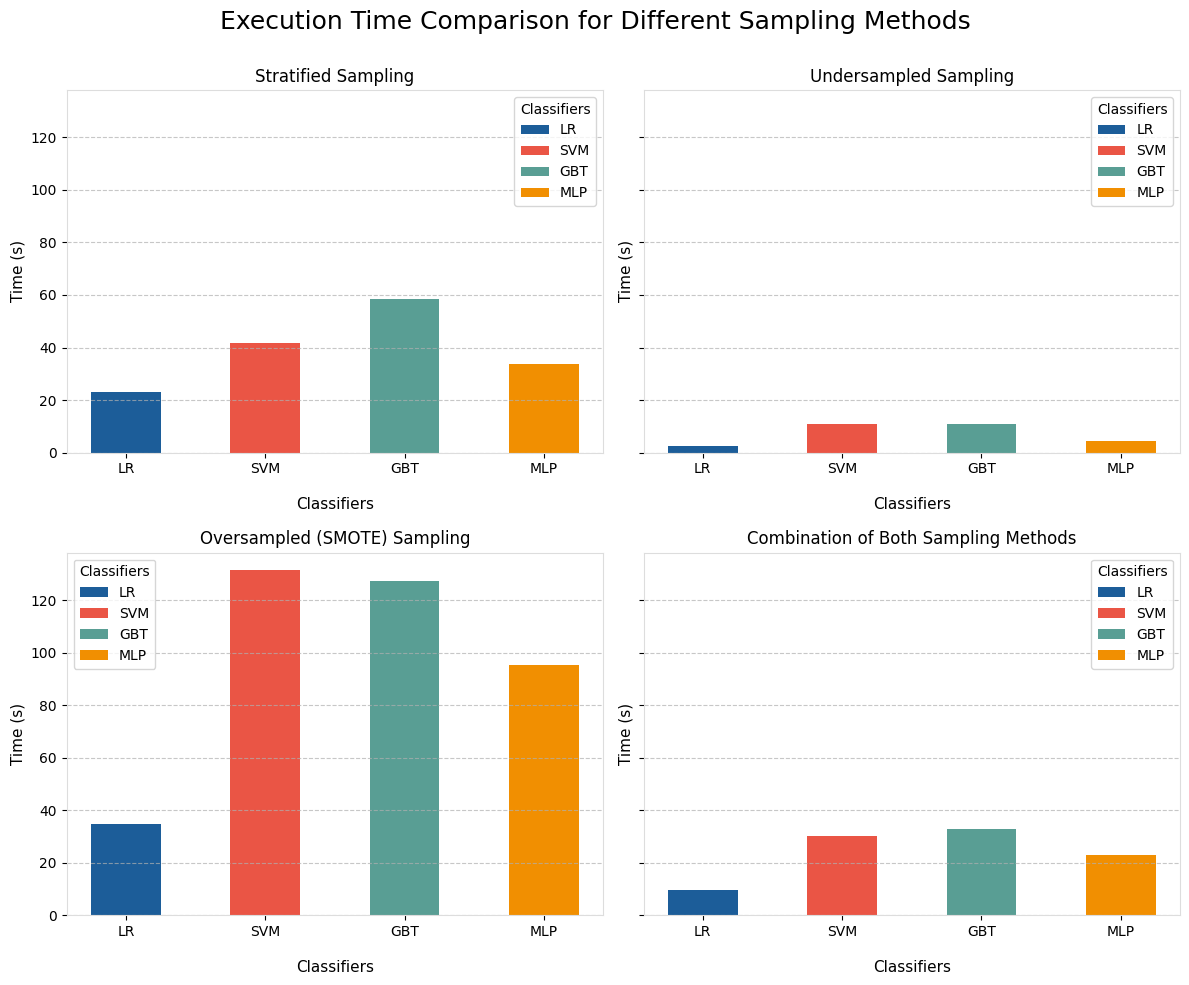

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# group the data by sampling method
methods = ['stratified', 'undersampled', 'oversampled', 'both']

# Plot settings
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

colors = ['#1C5D99', "#ea5545", '#599e94', '#F18F01']

bar_width = 0.5

# Generate subplots dynamically
for i, (ax, method) in enumerate(zip(axes, methods)):
    subset = execution_time_df[execution_time_df['Classifier'].str.contains(method)]
    classifiers = subset['Classifier'].str.split().str[0]

    # Plot each bar with a unique color
    for j, (classifier, time) in enumerate(zip(classifiers, subset['Total execution time'])):
        ax.bar(classifier, time, color=colors[j % len(colors)], width=bar_width, label=classifier)

    title = f"{method.capitalize()} Sampling"
    if method == 'oversampled':
        title = f"{method.capitalize()} (SMOTE) Sampling"
    elif method == 'both':
        title = f"Combination of Both Sampling Methods"

    ax.set_title(title, fontsize=12)

    ax.set_xlabel('Classifiers', fontsize=11, labelpad=15)
    ax.set_ylabel("Time (s)", fontsize=11)
    ax.legend(title='Classifiers', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # adjust spines' colors
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.spines['top'].set_color('#DDDDDD')
    ax.spines['right'].set_color('#DDDDDD')
    ax.spines['left'].set_color('#DDDDDD')

fig.suptitle("Execution Time Comparison for Different Sampling Methods", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.9)
plt.savefig('time_compare.png')
plt.show()

#### **Plot performance metric**

In [ ]:
fitted_models_and_pred_dict['GBT train with both method']['test_report']

{'AUC ROC': 0.9989459622930941,
 'Precision': 0.24343675417661098,
 'Recall': 0.9622641509433962,
 'F1-score': 0.38857142857142857}

In [ ]:
results = {}

text = ' train with '
classifiers = ['LR', 'SVM', 'GBT', 'MLP']

for method in methods:
    results[method] = {}
    for classifier in classifiers:
        metrics = {
            "F1-score": fitted_models_and_pred_dict[classifier + text + method + ' method']['test_report']['F1-score'],
            "Precision": fitted_models_and_pred_dict[classifier + text + method + ' method']['test_report']['Precision'],
            "Recall": fitted_models_and_pred_dict[classifier + text + method + ' method']['test_report']['Recall'],
            "AUC ROC": fitted_models_and_pred_dict[classifier + text + method + ' method']['test_report']['AUC ROC'],
        }
        results[method][classifier] = metrics

In [ ]:
results

{'stratified': {'LR': {'F1-score': 0.591715976331361,
   'Precision': 0.7936507936507936,
   'Recall': 0.4716981132075472,
   'AUC ROC': 0.9877861047587995},
  'SVM': {'F1-score': 0.807511737089202,
   'Precision': 0.8037383177570093,
   'Recall': 0.8113207547169812,
   'AUC ROC': 0.9576631065588628},
  'GBT': {'F1-score': 0.9306930693069307,
   'Precision': 0.9791666666666666,
   'Recall': 0.8867924528301887,
   'AUC ROC': 0.9981794641650203},
  'MLP': {'F1-score': 0.8956521739130434,
   'Precision': 0.8306451612903226,
   'Recall': 0.9716981132075472,
   'AUC ROC': 0.9984229313348578}},
 'undersampled': {'LR': {'F1-score': 0.14615958240119314,
   'Precision': 0.07935222672064778,
   'Recall': 0.9245283018867925,
   'AUC ROC': 0.9910654702213583},
  'SVM': {'F1-score': 0.1644295302013423,
   'Precision': 0.09023941068139964,
   'Recall': 0.9245283018867925,
   'AUC ROC': 0.9881936100927126},
  'GBT': {'F1-score': 0.0319903425381017,
   'Precision': 0.016255175586566476,
   'Recall': 1

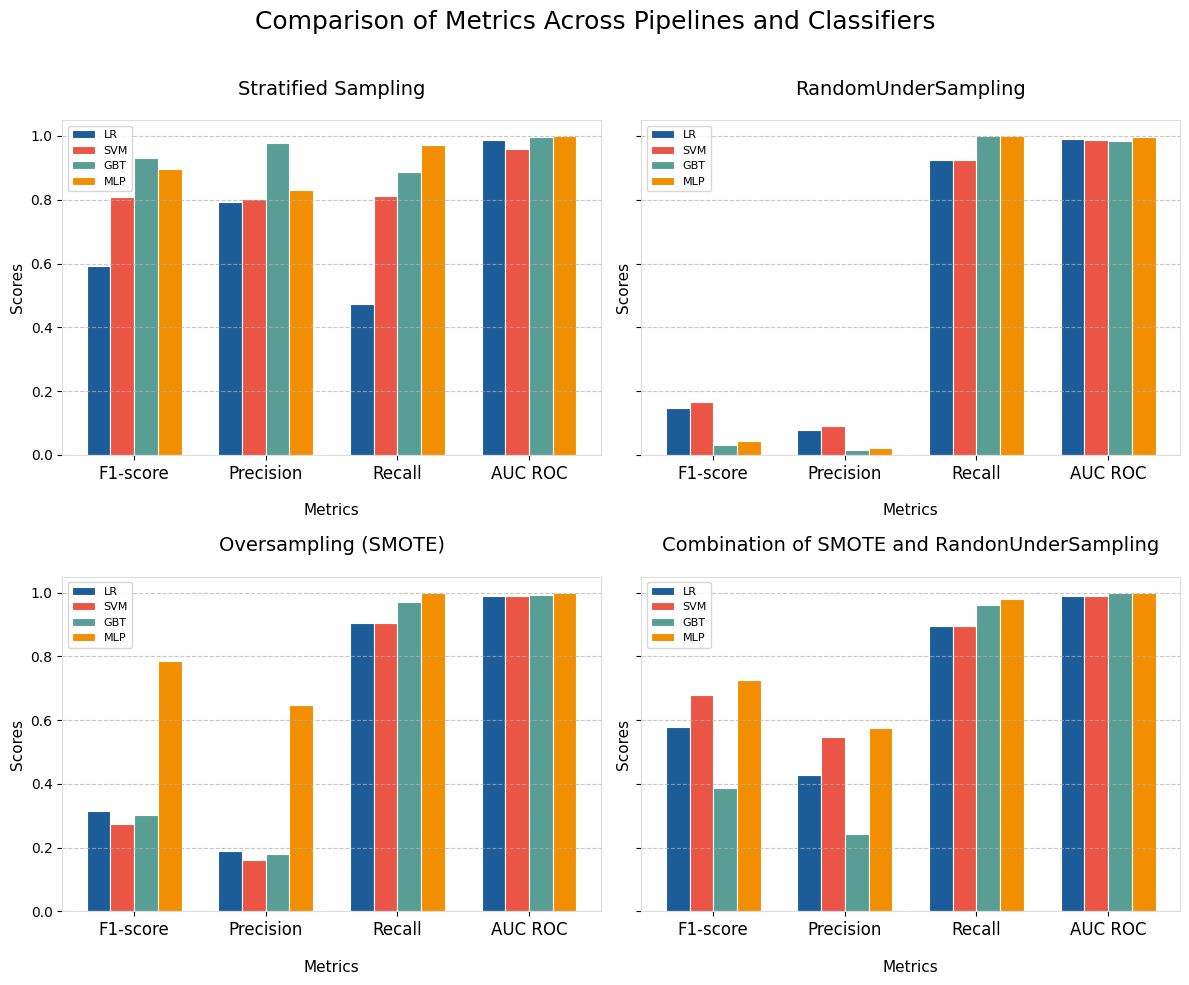

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['F1-score', 'Precision', 'Recall', 'AUC ROC']

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

pipeline_details = ['Stratified Sampling', 'RandomUnderSampling',
                    'Oversampling (SMOTE)', 'Combination of SMOTE and RandonUnderSampling']

bar_width = 0.18

for idx, (pipeline, pipeline_results) in enumerate(results.items()):
    classifiers = list(pipeline_results.keys())

    # extract scores for each metric and classifier
    scores = {metric: [pipeline_results[classifier][metric] for classifier in classifiers] for metric in metrics}

    x = np.arange(len(metrics))

    # current subplot
    ax = axes[idx]

    # plot each classifier's bars
    for i, classifier in enumerate(classifiers):
        ax.bar(x + i * bar_width, [scores[metric][i] for metric in metrics],
               bar_width, label=classifier, color=colors[i],
               edgecolor='white',
               linewidth=0.8)

    # customize the subplot
    ax.set_title(f'{pipeline_details[idx]}', fontsize=14, y=1.05)
    ax.set_xticks(x + bar_width * (len(classifiers) - 1) / 2)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.set_xlabel('Metrics', fontsize=11, labelpad=15)
    ax.set_ylabel('Scores', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # adjust spines' colors
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.spines['top'].set_color('#DDDDDD')
    ax.spines['right'].set_color('#DDDDDD')
    ax.spines['left'].set_color('#DDDDDD')

# set overall figure title and layout
fig.suptitle('Comparison of Metrics Across Pipelines and Classifiers', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.87)
plt.savefig('results_compare.png')
plt.show()

### **Feature importance**

In [ ]:
gbt_model_importance = gbt_final.fit(train_df_scaled)

importances = gbt_model_importance.featureImportances

# convert to a list of tuples for better readability
feature_importance_list = list(zip(vec_assembler.getInputCols(), importances.toArray()))

# sort by importance in descending order
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

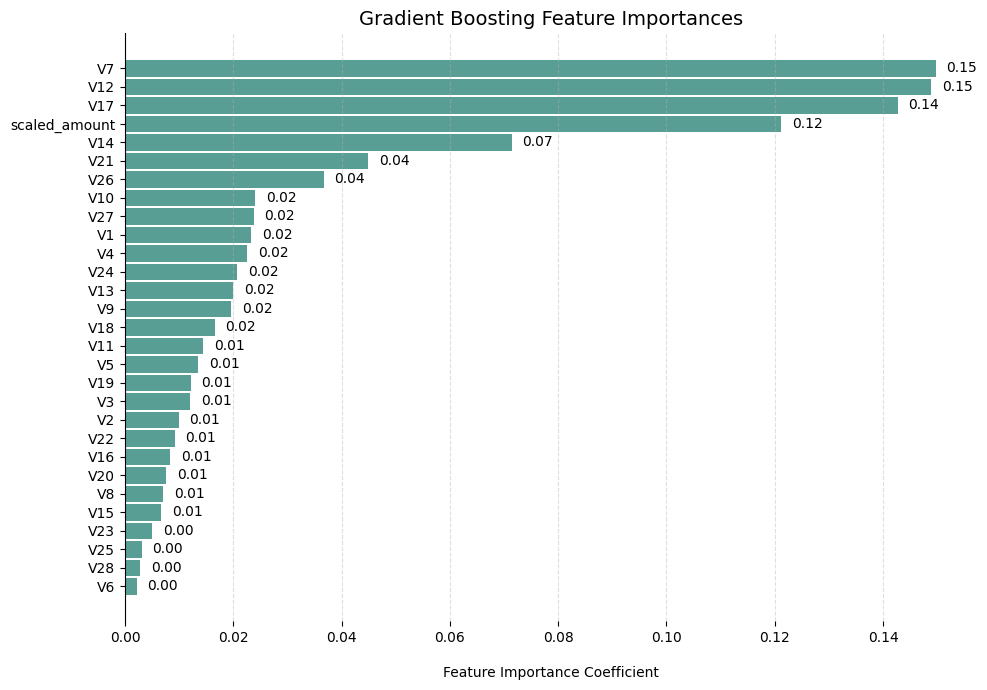

In [ ]:
# Convert to DataFrame for sorting
feature_importances_df = pd.DataFrame(feature_importance_list, columns=["Feature", "Importance"])

# Sort the features by importance
feature_importances_sorted = feature_importances_df.sort_values(by="Importance", ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 7))
bars = plt.barh(feature_importances_sorted["Feature"], feature_importances_sorted["Importance"],
                color='#599e94', height=0.9)

# Annotate importance scores next to each bar
for index, value in enumerate(feature_importances_sorted["Importance"]):
    plt.text(value + 0.002, index, f"{value:.2f}", va='center', fontsize=10)

# Plot formatting
plt.xlabel("Feature Importance Coefficient", labelpad=15)
plt.title("Gradient Boosting Feature Importances", fontsize=14)

plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()